<h1 id="Use-Keras-Pretrained-Models-dataset">1. Use Keras Pretrained Models dataset<a class="anchor-link" href="#Use-Keras-Pretrained-Models-dataset" target="_self">¶</a></h1><p>Kernels can't use network connection to download pretrained keras model weights.
This dataset helps you to apply your favorite pretrained model in the Kaggle Kernel environment. 
You can find more details <a href="https://www.kaggle.com/gaborfodor/keras-pretrained-models" target="_top">here</a>.</p>
<p>We have to copy the pretrained models to the cache directory (~/.keras/models) where keras is looking for them.</p>

In [1]:
!ls ../input/vgg16/

imagenet_class_index.json
vgg16_weights_tf_dim_ordering_tf_kernels.h5
vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5


In [2]:
import os
cache_dir = os.path.expanduser(os.path.join('~', '.keras'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [3]:
!cp ../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5 ~/.keras/models/

In [4]:
print(os.listdir('../input/plant-seedlings-classification/train/'))

['Maize', 'Fat Hen', 'Common Chickweed', 'Cleavers', 'Charlock', 'Loose Silky-bent', 'Small-flowered Cranesbill', 'Black-grass', 'Scentless Mayweed', 'Sugar beet', 'Common wheat', 'Shepherds Purse']


In [5]:
import fnmatch
import os
import numpy as np
import pandas as pd
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
np.random.seed(21)

path = '../input/plant-seedlings-classification/train/'
train_label = []
train_img = []
label2num = {'Loose Silky-bent':0, 'Charlock':1, 'Sugar beet':2, 'Small-flowered Cranesbill':3,
             'Common Chickweed':4, 'Common wheat':5, 'Maize':6, 'Cleavers':7, 'Scentless Mayweed':8,
             'Fat Hen':9, 'Black-grass':10, 'Shepherds Purse':11}
for i in os.listdir(path):
    label_number = label2num[i]
    new_path = path+i+'/'
    for j in fnmatch.filter(os.listdir(new_path), '*.png'):
        temp_img = image.load_img(new_path+j, target_size=(200,200))
        train_label.append(label_number)
        temp_img = image.img_to_array(temp_img)
        train_img.append(temp_img)

train_img = np.array(train_img)

train_y=pd.get_dummies(train_label)
train_y = np.array(train_y)
train_img=preprocess_input(train_img)

print('Training data shape: ', train_img.shape)
print('Training labels shape: ', train_y.shape)

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Training data shape:  (4750, 200, 200, 3)
Training labels shape:  (4750, 12)


In [6]:
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator

def vgg16_model(num_classes=None):

    model = VGG16(weights='imagenet', include_top=False,input_shape=(200,200,3))
    model.layers.pop()
    model.layers.pop()
    model.layers.pop()

    model.outputs = [model.layers[-1].output]

    model.layers[-2].outbound_nodes= []
    x=Conv2D(256, kernel_size=(2,2),strides=2)(model.output)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    x=Conv2D(128, kernel_size=(2,2),strides=1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x=Flatten()(x)
    x=Dense(num_classes, activation='softmax')(x)

    model=Model(model.input,x)

    for layer in model.layers[:15]:

        layer.trainable = False


    return model

In [7]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

In [8]:
from keras import backend as K
num_classes=12
model = vgg16_model(num_classes)
model.compile(optimizer="nadam", loss='categorical_crossentropy', metrics=['accuracy',fscore])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200, 200, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0         
__________

In [9]:
#Split training data into rain set and validation set
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(train_img,train_y,test_size=0.1, random_state=42)

#Data augmentation
'''from keras.preprocessing.image import ImageDataGenerator
gen_train = ImageDataGenerator( 
    rotation_range=30,
    width_shift_range=0.2,
   height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True

)
gen_train.fit(X_train)

#Train model
from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

model.fit_generator(gen_train.flow(X_train, Y_train, batch_size=batch_size, shuffle=True), 
                    steps_per_epoch=(X_train.shape[0]//(4*batch_size)), 
                    epochs=epochs, 
                    validation_data=(X_valid,Y_valid),
                    callbacks=[model_checkpoint],verbose=1)
'''
from keras.callbacks import ModelCheckpoint
epochs = 10
batch_size = 32
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

model.fit(X_train,Y_train,
          batch_size=128,
          epochs=20,
          verbose=1, shuffle=True, validation_data=(X_valid,Y_valid), callbacks=[model_checkpoint])

Train on 4275 samples, validate on 475 samples
Epoch 1/20
4275/4275 [==============================] - 59s 14ms/step - loss: 1.3224 - acc: 0.5633 - fscore: 0.4934 - val_loss: 4.3251 - val_acc: 0.2905 - val_fscore: 0.2879
Epoch 2/20
4275/4275 [==============================] - 41s 10ms/step - loss: 0.4603 - acc: 0.8437 - fscore: 0.8353 - val_loss: 5.4486 - val_acc: 0.2442 - val_fscore: 0.2320
Epoch 3/20
4275/4275 [==============================] - 41s 10ms/step - loss: 0.2866 - acc: 0.9053 - fscore: 0.9034 - val_loss: 1.4545 - val_acc: 0.5600 - val_fscore: 0.5565
Epoch 4/20
4275/4275 [==============================] - 41s 10ms/step - loss: 0.1990 - acc: 0.9338 - fscore: 0.9348 - val_loss: 0.4683 - val_acc: 0.8484 - val_fscore: 0.8496
Epoch 5/20
4275/4275 [==============================] - 41s 10ms/step - loss: 0.1248 - acc: 0.9630 - fscore: 0.9621 - val_loss: 1.0986 - val_acc: 0.6653 - val_fscore: 0.6703
Epoch 6/20
4275/4275 [==============================] - 41s 10ms/step - loss: 0.086

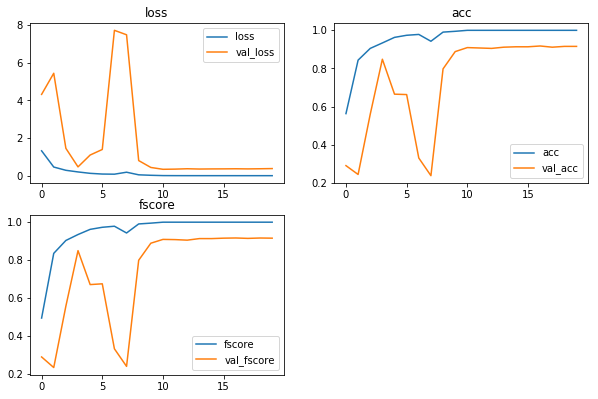

In [10]:
import matplotlib.pyplot as plt
def plot_model(model):
    plots = [i for i in model.history.history.keys() if i.find('val_') == -1]
    plt.figure(figsize=(10,10))

    for i, p in enumerate(plots):
        plt.subplot(len(plots), 2, i + 1)
        plt.title(p)
        plt.plot(model.history.history[p], label=p)
        plt.plot(model.history.history['val_'+p], label='val_'+p)
        plt.legend()

    plt.show()
    
plot_model(model)

In [11]:
model.load_weights('weights.h5')

In [12]:
prob=[]
num=[]
test_img=[]
test_path = '../input/plant-seedlings-classification/test/'
test_all = fnmatch.filter(os.listdir(test_path), '*.png')

test_img=[]
for i in range(len(test_all)):
    path=test_path+'/'+test_all[i]
    temp_img=image.load_img(path,target_size=(200,200))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img) 
test_img=np.array(test_img)    
test_img=preprocess_input(test_img)


test_labels=[]
pred=model.predict(test_img)
num2label =  {0:'Loose Silky-bent', 1:'Charlock',2: 'Sugar beet',3: 'Small-flowered Cranesbill',
              4:'Common Chickweed',5: 'Common wheat',6: 'Maize', 7:'Cleavers', 8:'Scentless Mayweed',
             9: 'Fat Hen', 10:'Black-grass', 11:'Shepherds Purse'}
for i in range(len(test_all)):
    max_score =0
    lab=-1
    for j in range(12):
        if pred[i][j]>max_score:
            max_score=pred[i][j]
            lab=j
    test_labels.append(num2label[lab])


d = {'file': test_all, 'species': test_labels}
df = pd.DataFrame(data=d)
print(df.head(50))

             file                    species
0   0e8492cb1.png                      Maize
1   b687160f5.png  Small-flowered Cranesbill
2   fea3da57c.png                 Sugar beet
3   f6d250856.png            Shepherds Purse
4   e73e308be.png                    Fat Hen
5   9cce7328c.png           Loose Silky-bent
6   1191ba346.png                   Cleavers
7   0c27cf05f.png           Loose Silky-bent
8   a060c1cf8.png                      Maize
9   241e6935a.png                 Sugar beet
10  606647f64.png           Common Chickweed
11  5eb9c26a6.png           Loose Silky-bent
12  03ef36742.png          Scentless Mayweed
13  1364b297a.png                   Cleavers
14  f9f35cbd4.png           Common Chickweed
15  99569b224.png               Common wheat
16  599691cd9.png  Small-flowered Cranesbill
17  d8f4923f8.png           Common Chickweed
18  ec08a5d56.png  Small-flowered Cranesbill
19  a935ca110.png           Loose Silky-bent
20  29f49cd0b.png                    Fat Hen
21  87f627

In [13]:
#Convert dataframe to csv
# df.to_csv("submit.csv",index=False)